In [2]:
from hossam import load_data
from pandas import DataFrame
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
import numpy as np

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
my_dpi=200
font_path='../NotoSansKR-Regular.ttf'
fm.fontManager.addfont(font_path)
font_prop=fm.FontProperties(fname=font_path)
font_name=font_prop.get_name()
plt.rcParams['font.family']=font_name
plt.rcParams['font.size']=6
plt.rcParams['axes.unicode_minus']=False

In [4]:
origin=load_data('air_passengers')
print('\n===== 데이터 크기 확인 =====')
print(f'데이터셋 크기 : {origin.shape}')
print(f'행 개수 : {origin.shape[0]}개')
print(f'열 개수 : {origin.shape[1]}개')
print('\n===== 타입 확인 =====')
print(origin.info())
origin.head()

[data] https://data.hossam.kr/data/lab13_/air_passengers.xlsx
[desc] 어느 항공사의 월간 탑승객 수 (출처: https://www.kaggle.com/datasets/rakannimer/air-passengers)
[!] Cannot read metadata

===== 데이터 크기 확인 =====
데이터셋 크기 : (144, 2)
행 개수 : 144개
열 개수 : 2개

===== 타입 확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       144 non-null    datetime64[ns]
 1   Passengers  144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB
None


,Month,Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


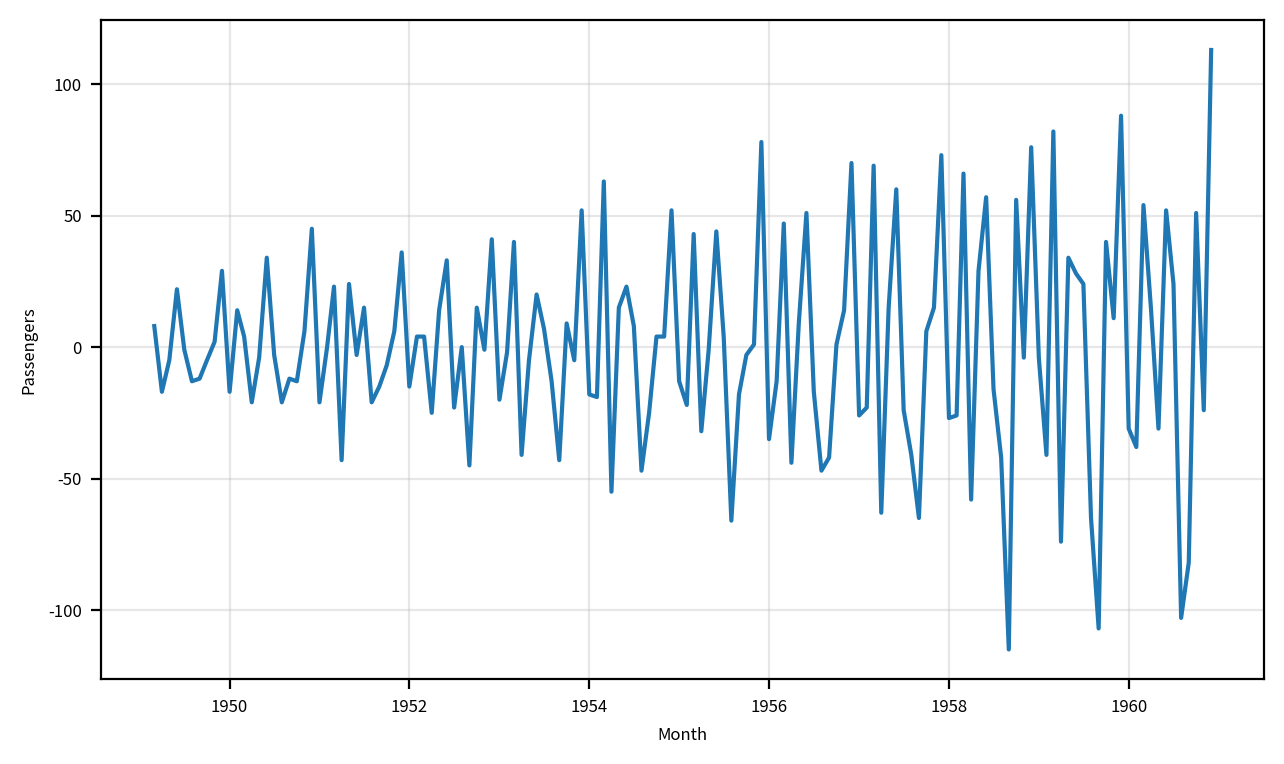

,2회 차분 결과
검정통계량(ADF Statistic),-16.384232
유의수준(p-value),0.0
최적차수(num of lags),11
관측치 개수(num of observations),130
정상성,True


In [5]:
# 데이터 입력
time_name='Month'                    # 시간 데이터 입력
yname='Passengers'                        # 변수 데이터 입력

# 패키지 참조
from pandas import DataFrame
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

# 그래프 초기화
my_dpi=200
font_path='../NotoSansKR-Regular.ttf'
fm.fontManager.addfont(font_path)
font_prop=fm.FontProperties(fname=font_path)
font_name=font_prop.get_name()
plt.rcParams['font.family']=font_name
plt.rcParams['font.size']=6
plt.rcParams['axes.unicode_minus']=False

# 차분을 통한 데이터 정상성 확보
df=origin.set_index(time_name)
diff_df=df.copy()
count=0
while True:
    ar=adfuller(diff_df[yname])
    if ar[1]<=0.05:
        width_px=1280
        height_px=760
        rows=1
        cols=1
        figsize=(width_px/my_dpi, height_px/my_dpi)
        fig, ax=plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)
        sb.lineplot(data=diff_df, x=diff_df.index, y='Passengers')
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        plt.close()

        ar_dict={
            '검정통계량(ADF Statistic)':ar[0],
            '유의수준(p-value)':ar[1],
            '최적차수(num of lags)':ar[2],
            '관측치 개수(num of observations)':ar[3],
            '정상성':True
        }
        adf=DataFrame([ar_dict]).T
        adf=adf.rename(columns={0:f'{count}회 차분 결과'})
        display(adf)
        break
    diff_df=diff_df.diff().dropna()
    count+=1

In [6]:
acf_vals=acf(diff_df[yname])
threshold=2/np.sqrt(len(diff_df[yname]))
significant_lags=np.where(np.abs(acf_vals)>threshold)[0]

acf_vals, threshold, significant_lags

(array([ 1.        , -0.19100587, -0.19598169, -0.0485473 , -0.20664662,
         0.11939696,  0.02575129,  0.14558204, -0.22613908,  0.01407533,
        -0.2082756 , -0.12089977,  0.78224898, -0.09592873, -0.19547382,
        -0.07034343, -0.14794844,  0.11319557,  0.01921939,  0.13695131,
        -0.24015233,  0.02613065]),
 np.float64(0.16783627165933782),
 array([ 0,  1,  2,  4,  8, 10, 12, 14, 20]))

In [ ]:
acf_vals=acf(diff_df[yname])
threshold=2/np.sqrt(len(diff_df[yname]))

df_acf=DataFrame({
    'lag':np.arange(len(acf_vals)),
    'acf':acf_vals
})

df_acf['abs_acf']=df_acf['acf'].abs().round(3)
df_acf['significant']=df_acf['abs_acf']>threshold
df_acf['acf']=df_acf['acf'].round(3)
df_acf['threshold']=round(threshold,3)

df_acf_result=df_acf.query('lag>0').reset_index(drop=True)

df_acf_result['prev_significant']=df_acf_result['significant'].shift(1)
df_acf_result['cut_candidate']=(
    (df_acf_result['prev_significant']==True)&
    (df_acf_result['significant']==False)
)

# df_acf_result[['lag','acf','significant','cut_candidate']]

df_acf_result

,lag,acf,abs_acf,significant,threshold,prev_significant,cut_candidate
0,1,-0.191,0.191,True,0.168,NaN,False
1,2,-0.196,0.196,True,0.168,True,False
2,3,-0.049,0.049,False,0.168,True,True
3,4,-0.207,0.207,True,0.168,False,False
4,5,0.119,0.119,False,0.168,True,True
5,6,0.026,0.026,False,0.168,False,False
6,7,0.146,0.146,False,0.168,False,False
7,8,-0.226,0.226,True,0.168,False,False
8,9,0.014,0.014,False,0.168,True,True
9,10,-0.208,0.208,True,0.168,False,False


In [14]:
q_candidate=df_acf_result.loc[df_acf_result['cut_candidate'],'lag'].min()-1
q_candidate

np.int64(2)

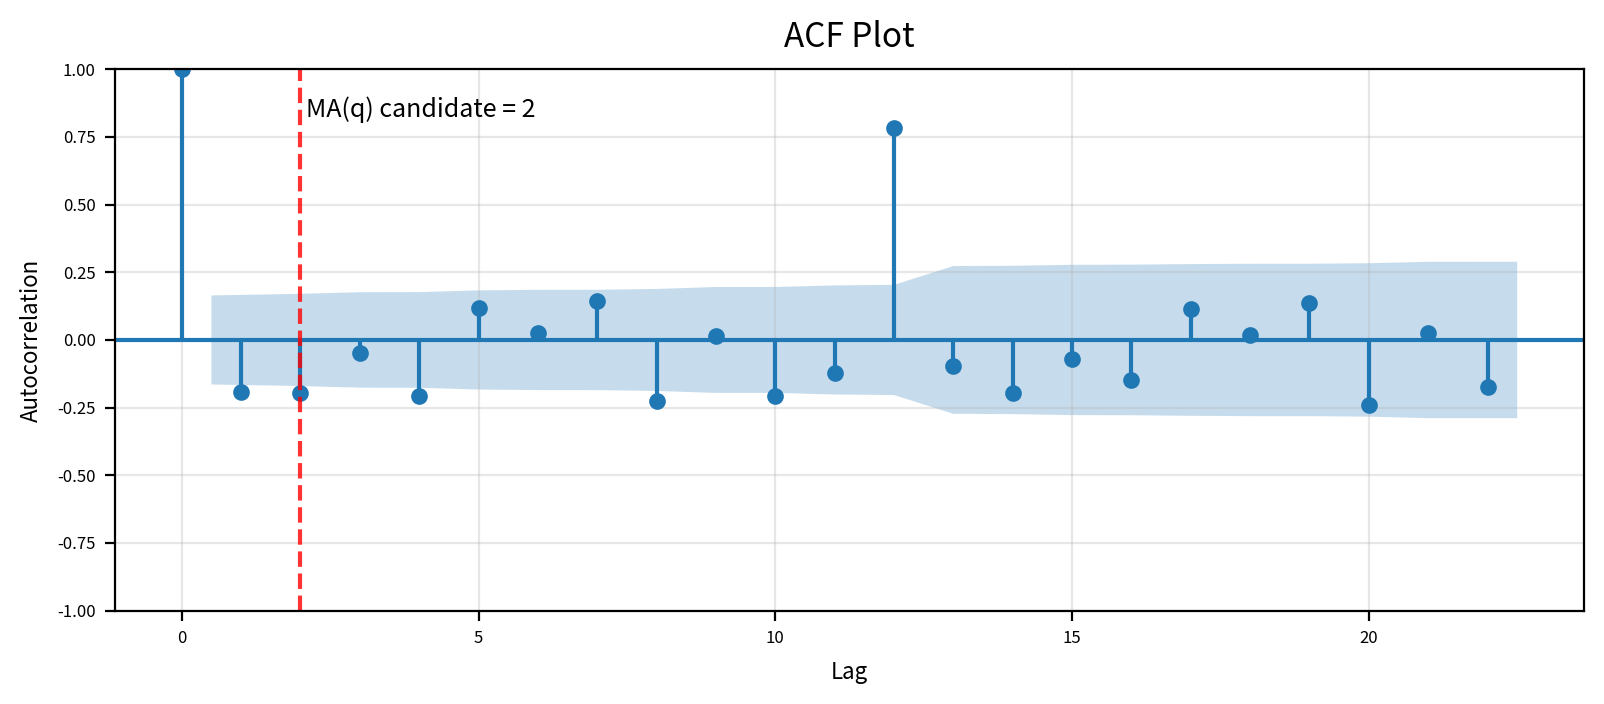

In [15]:
width_px=1600
height_px=700
rows=1
cols=1
figsize=(width_px/my_dpi, height_px/my_dpi)
fig, ax=plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

plot_acf(diff_df[yname], ax=ax)

ax.axvline(
    x=q_candidate,
    linestyle='--',
    linewidth=1.5,
    alpha=0.8,
    color='red'
)
ax.text(
    q_candidate+0.1,
    ax.get_ylim()[1]*0.9,
    f'MA(q) candidate = {q_candidate}',
    fontsize=9,
    verticalalignment='top'
)

ax.set_title('ACF Plot', fontsize=12, pad=8)
ax.set_xlabel('Lag', fontsize=8, labelpad=5)
ax.set_ylabel('Autocorrelation', fontsize=8, labelpad=5)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close()

In [16]:
pacf_vals=pacf(diff_df[yname])

df_pacf=DataFrame({
    'lag':np.arange(len(pacf_vals)),
    'pacf':pacf_vals
})

df_pacf['abs_pacf']=df_pacf['pacf'].abs().round(3)
df_pacf['significant']=df_pacf['abs_pacf']>threshold
df_pacf['pacf']=df_pacf['pacf'].round(3)
df_pacf['threshold']=round(threshold,3)

df_pacf_result=df_pacf.query('lag>0').reset_index(drop=True)

df_pacf_result['prev_significant']=df_pacf_result['significant'].shift(1)
df_pacf_result['cut_candidate']=(
    (df_pacf_result['prev_significant']==True)&
    (df_pacf_result['significant']==False)
)

# df_pacf_result[['lag','acf','significant','cut_candidate']]

df_pacf_result

,lag,pacf,abs_pacf,significant,threshold,prev_significant,cut_candidate
0,1,-0.192,0.192,True,0.168,NaN,False
1,2,-0.245,0.245,True,0.168,True,False
2,3,-0.159,0.159,False,0.168,True,True
3,4,-0.355,0.355,True,0.168,False,False
4,5,-0.112,0.112,False,0.168,True,True
5,6,-0.169,0.169,True,0.168,False,False
6,7,0.078,0.078,False,0.168,True,True
7,8,-0.329,0.329,True,0.168,False,False
8,9,-0.075,0.075,False,0.168,True,True
9,10,-0.596,0.596,True,0.168,False,False


In [17]:
p_candidate=df_pacf_result.loc[df_pacf_result['cut_candidate'],'lag'].min()-1
p_candidate

np.int64(2)

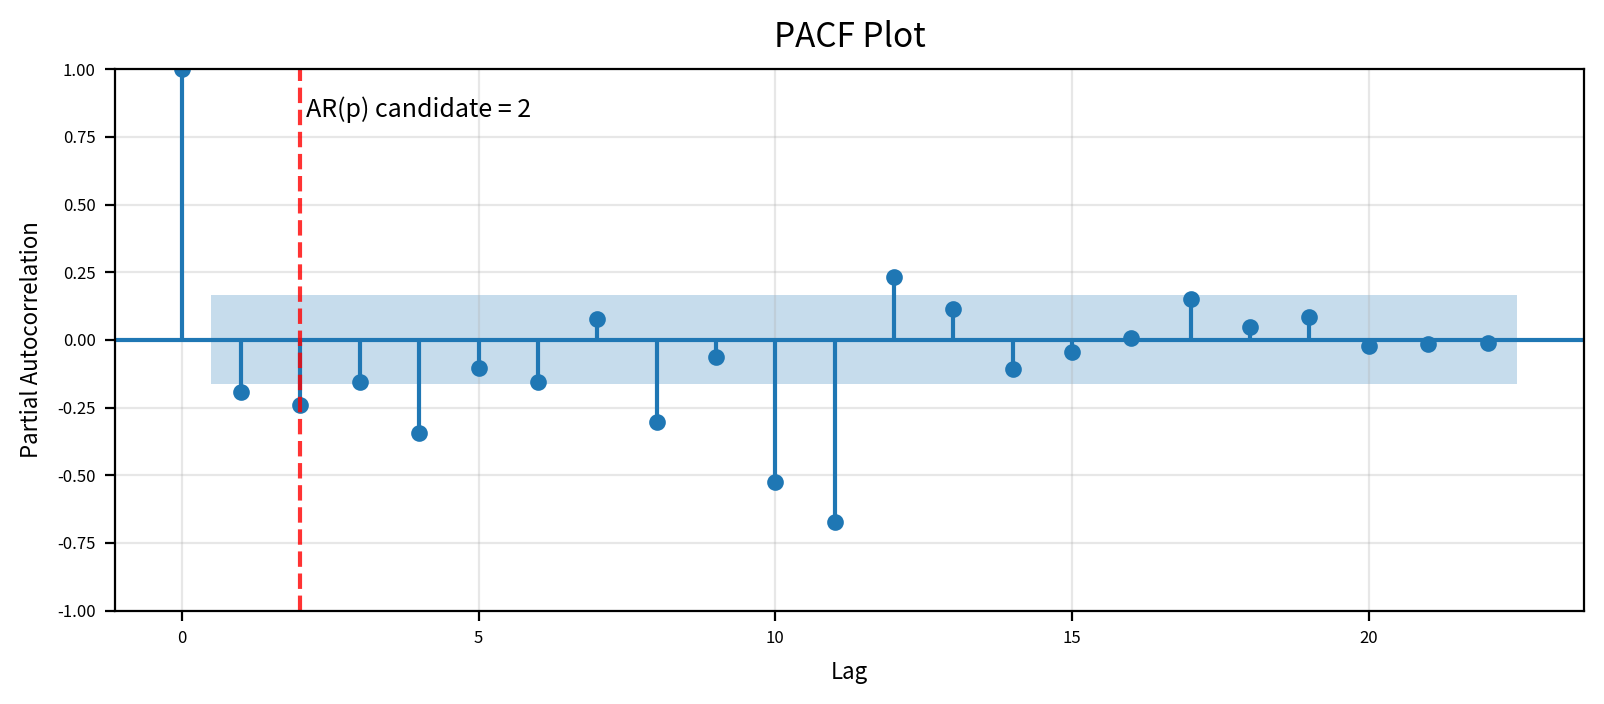

In [18]:
width_px=1600
height_px=700
rows=1
cols=1
figsize=(width_px/my_dpi, height_px/my_dpi)
fig, ax=plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

plot_pacf(diff_df[yname], ax=ax)

ax.axvline(
    x=p_candidate,
    linestyle='--',
    linewidth=1.5,
    alpha=0.8,
    color='red'
)
ax.text(
    p_candidate+0.1,
    ax.get_ylim()[1]*0.9,
    f'AR(p) candidate = {p_candidate}',
    fontsize=9,
    verticalalignment='top'
)

ax.set_title('PACF Plot', fontsize=12, pad=8)
ax.set_xlabel('Lag', fontsize=8, labelpad=5)
ax.set_ylabel('Partial Autocorrelation', fontsize=8, labelpad=5)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close()